# Optimising Model Parameters Using the Evolutionary Optimizers

In [23]:
from pprint import pprint
import matplotlib.pyplot as plt
import nglview as nv
import isambard.specifications as specs
import isambard.modelling as modelling
%matplotlib inline

In [24]:
import isambard
import isambard.optimisation.evo_optimizers as ev_opts
from isambard.optimisation.evo_optimizers import Parameter

In [25]:
def show_ball_and_stick(ampal):
    view = nv.show_text(ampal.pdb)
    view.add_ball_and_stick()
    view.remove_cartoon()
    return view

## Getting Ready

Three things are required to run an optimisation:

1. A specification
1. A list of amino-acid sequences to be packed onto the model
1. A list of parameters

The first two are pretty straight forward, chances are you know the specification you want to use and the sequence you want to optimize. In this example I'll use the `CoiledCoil` specification, using the `from_parameters` class method and I'll use the sequence for the [basis-set dimer](http://www.rcsb.org/pdb/explore/explore.do?structureId=4DZM).

In [26]:
specification = specs.CoiledCoil.from_parameters

In [27]:
sequences = ['EIAALKQEIAALKKENAALKWEIAALKQ', 'EIAALKQEIAALKKENAALKWEIAALKQ']

So far, so simple, but parameters require a bit more effort to set up.

### Parameters

If we look at the signature of `CoiledCoil.from_parameters` it looks like this:

```
from_parameters(
    n,
    aa=28,
    major_radius=None,
    major_pitch=None,
    phi_c_alpha=26.42,
    minor_helix_type='alpha',
    auto_build=True
    )
```

It is expecting arguments in this order, so we need to supply parameters to the optimizer that match this format. We can make a list of parameters using the `Parameter` class:

In [28]:
parameters = [
    Parameter.static('Oligomeric State', 2),
    Parameter.static('Helix Length', 28),
    Parameter.dynamic('Radius', 5.0, 1.0),
    Parameter.dynamic('Pitch', 200, 60),
    Parameter.dynamic('PhiCA', 283, 27),  # 283 is equivalent to a g position
]

In [29]:
parameters

[<Parameter: Oligomeric State, ParameterType.STATIC>,
 <Parameter: Helix Length, ParameterType.STATIC>,
 <Parameter: Radius, ParameterType.DYNAMIC>,
 <Parameter: Pitch, ParameterType.DYNAMIC>,
 <Parameter: PhiCA, ParameterType.DYNAMIC>]

> ### Note
> "Parameters" in the `from_parameters` class method name is referring to the geometric parameters that describe a coiled-coil, not the `Parameter` class in the `evo_optimizer` module.

`Parameter`s can be created using the `static` or `dynamic` class method. `Parameter`s created with `Parameter.static` will have fixed values during optimisation, whereas those created with `Parameter.dynamic` will be modified by the optimizer.

The parameters are created using the following arguments:

```python
Parameter.static('Oligomeric State', 2)
#                ^                   ^___ The static value
#                |___ a human readable label

Parameter.dynamic('Radius', 5.0, 1.0)
#                 ^         ^    ^___ Value range
#                 |         |___ Mean value
#                 |___ a human readable label


```

Both parameter types have a human-readable label. This is for your own reference really, you can use anything you like, as long as you know what parameter it corresponds to. Static parameters have a single value supplied, while the dynamic value has a mean value and a range. For example, in the radius parameter, we've given a mean value of `5.0`, with a range of `1.0`, this means that the optimizer can create values for radius of between `4.0` and `6.0`.

Once you've made your parameter list you can test it to see if it can be used to generate a model correctly:

In [30]:
default_values = [x.default_value for x in parameters]
print(default_values)

[2, 28, 5.0, 200, 283]


The `default_value` property returns either the static value or the mean of a set of dynamic values. We can unpack this list in order to supply arguments to the specification.

In [31]:
test_model = specification(*default_values)
print(test_model)

<Assembly containing 2 Polypeptides>


In [33]:
print(test_model.major_radii)
print(test_model.major_pitches)
print(test_model.phi_c_alphas)

[5.0, 5.0]
[200, 200]
[283, 283]


As you can see, the model was created as expected using the values we supplied for the parameters. Now we're ready to run an optimisation.

## Running an Optimisation

Once you have all these things in place, you're ready to initialise the optimizer. There are 4 different evolutionary optimizers in the `evo_optimizers` module:

1. `GA` (Genetic Algorithm) - Good at eliminating unfavourable regions of parameter space.
1. `DE` (Differential Evolution) - A simple and versatile algorithm that quickly finds the minima in smooth energy landscapes.
1. `PSO` - (Particle Swarm Optimisation) - A noisy algorithm that explores a lot of the parameter space.
1. `CMAES` - (Covariance Matrix Adaptive Evolutionary Strategy) - Thoroughly explores regions of parameter space that are likely to contain the minima.

> ### Note
> It's difficult to know which algorithm is going to be best for your problem, so it's a good idea to try out all of them on a small scale. If you're really unsure about which one to use, the `GA` provides a good balance of parameter-space coverage and thoroughness.

Let's take a look at the signature for the `GA`:

```python
# init signature
GA(specification, sequences, parameters, build_fn, eval_fn,
   cxpb=0.5, mutpb=0.2, **kwargs)
```

Here you can see that the `GA`, and in fact all of the evolutionary optimizers, have 5 required arguments to initialize them. We've already sorted out the first three (specification, sequence and parameters), what about `build_fn` and `eval_fn`? These arguments are functions that the optimizer will use to build a model from the parameters it generates and then to evaluate those models. This means that the optimizers are highly customisable (ask someone if you'd like to know more about this), but to get started, you might want to use the optimizer with predefined build and evaluation functions.

In [38]:
def get_bude_total_energy(ampal_object):
    return budeff.get_internal_energy(ampal_object).total_energy

opt_ga = ev_opts.GA(specification, sequences, parameters, get_bude_total_energy)



**Running the next command might take a while! ~1 mins.**

In [39]:
opt_ga.run_opt(100, 5, cores=4)

gen	evals	avg     	std    	min     	max     
0  	70   	-806.907	32.3501	-904.367	-748.522
1  	67   	-846.15 	29.765 	-941.384	-802.866
2  	74   	-875.445	24.7083	-955.194	-840.128
3  	71   	-895.402	23.4932	-968.037	-866.993
4  	65   	-916.435	24.0867	-971.861	-879.839
Evaluated 447 models in total in 0:00:38.642399
Best fitness is (-971.86130042638,)
Best parameters are [2, 28, 4.6638892571706005, 152.42605074236337, 277.09565800321013]


The optimizer prints various statistics about the optimisation both as it's running and after it finishes. After each generation is complete, a range of information about that generation is printed:

* **gen** - the generation number
* **evals** - the number of models built and evaluated in that generation. Even though a specific `pop_size` is specified, not all models are built, as models with the same or very similar parameters are not recreated. This is most obvious in the `GA` where parameters with a high "fitness" are retained in the subsequent generation.
* **avg** - the average value of the evaluation metric for the generation.
* **std** - the standard deviation of the evaluation metric for the generation.
* **min** - the lowest (best) score in the generation.
* **max** - the highest (worst) score in the generation.

> ### Note
> This logging information can be written to disk using the `log`, `log_path` and `run_id` keyword arguments on `run_opt`.

Once the optimisation has finished, the parameters and score for the best model are printed. You can get the AMPAL object for the best model by using the `best_model` property:

In [40]:
optimized_model = opt_ga.best_model
print(optimized_model)

<Assembly containing 2 Polypeptides>


You can then write the PDB to a file and take a look at your optimized model:

In [41]:
show_ball_and_stick(optimized_model)

NGLWidget()

Of course, this was a very quick optimisation, and to find something closer to the global minima you may need larger values for `pop_size` and `generations`. The std column of output printed by the optimizer gives a good indication of the degree of convergence on a single solution during optimisation, but you should be critical of the optimisation, running it multiple times and evaluating the models produced thoroughly.

## Evaluating an Optimisation

There are some tools in the optimizer that can give information about the optimisation run that we have performed. The most useful of these is the `make_energy_funnel_data` function, which compares all of the models created during the optimisation to the best model produced.

In [42]:
funnel_data = opt_ga.make_energy_funnel_data()

In [19]:
pprint(funnel_data[:5])

[(0.9141121336217, -394.18474617150326, 0),
 (0.9851860583941823, -810.1399548670672, 0),
 (1.0209067660279312, -800.030497982921, 0),
 (2.023021419053678, -768.5057801507047, 0),
 (1.4032703311009873, -566.38887740557, 0)]


`make_energy_funnel_data` returns a list of tuples containing the RMSD between a model and the best model from the optimisation, the BUFF internal energy for that model and the generation that the model came from. We can use these data to make a plot showing gross properties of the optimisation:

In [43]:
xs = [x[0] for x in funnel_data]
ys = [x[1] for x in funnel_data]
zs = [x[2] for x in funnel_data]

Text(0, 0.5, 'BUFF Internal Energy')

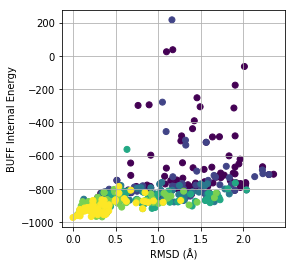

In [44]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

In this plot, every model produced by the optimizer is shown as a point, with its BUFF internal energy as the Y axis and the RMSD from the best scoring model as the X axis. The colour represents the generation, purple is the first generation and yellow is the last generation.

You can see that there is some sort of structure to the data points, which makes sense; if models have similar RMSDs, they should probably have a similar BUFF internal energy.

Let's take a closer look at the best scoring models:

Text(0, 0.5, 'BUFF Internal Energy')

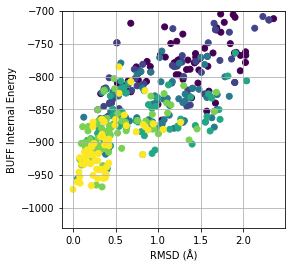

In [45]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_ylim(top=-700)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

You can clearly see here that later generations have better scores, although this is specific to the `GA`, other optimisation algorithms may or may not do this depending on how they search the solution space.

The most interesting thing about this plot is that you can see that there is a clear minimum, which indicates that this optimisation has converged well. However, there are a number of reasons you might not see this with your optimisation:

1. You haven't sampled enough, increase the `pop_size` or number of `generations`
1. Your sequence or parameterisation may not have a single deep minima, and might instead have a few similar minima or be quite smooth in general. This could mean that your sequence is quite plastic, allowing a large number of comformations to be adopted.

> ### Problem
> Try running this optimisation using some of the other optimizer classes (`ev_opts.PSO`, `ev_opts.DE` or `ev_opts.CMAES`). Does the energy funnel look different? Has the optimizer found the same solution?

## Conclusions

The evolutionary optimizers are very effective at searching parameter space, and can be used to fit parameters to a specific amino-acid sequence. Don't forget though that the optimizers are not magic bullets, and the output must be thoroughly scrutinized. If the optimization is not producing sensible results, try changing the evaluation function, it's easy to use your favorite all-atom force field, or even better, produce a meta-score combining a range of different metrics!